# Q-learning

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

def utility_func(t, W, alpha=0.1):
  if t == 10:
    reward = -np.exp(-alpha*W)/alpha
  else:
    reward = 0
  return reward

# Function to find the maximum Q-value or action
def find_max_qvalue(qvalue_dict, state, status, action_space=action_space):
    max_value = -np.inf
    max_action = []
    for act in action_space:
      q_value = qvalue_dict.get((state, act),-np.inf) # Default value for missing keys
      if q_value > max_value:
        max_value = q_value
        max_action = [act]
    if status == "value":
      return max_value
    elif status == "action":
      return max_action[0]


In [ ]:
# Problem parameters
# a, b, p for risky return
# risky return has p probability to get return a; 1-p probability to get return b
risky_return = {"high": (0.2, -0.1, 0.6), 
                "equal": (0.15, -0.1, 0.6),
                "low": (0.1, -0.1, 0.6)}
T = 10  # Time horizon
alpha = 0.1 # Utility Parameter
r = 0.05 # Risk-free rate
gamma = 0.9  # Discounted factor
step_size = 0.01  # Learning rate
epsilon = 0.4  # Exploration rate
max_episodes = 1000000  # Maximum number of episodes
W0 = 1 # initial wealth
value_function_changes_list = defaultdict(list)
state_space = [(t, round(W, 1)) for t in range(T + 1) for W in np.arange(-50, 50, 0.1)] # states of time and wealth
action_space = [0.2,0.4,0.6,0.8,"optimal_action"] # fraction of wealth allocate to risky asset

# Initialize Q-function: Assume all initial value = -np.exp(-alpha*W0)/alpha
Q = {}
initial_value = -np.exp(-alpha*W0)/alpha
for state in state_space:
  for action in action_space:
    Q[(state, action)] = initial_value 

# Q Learning
for para in risky_return.keys():
  a, b, p = risky_return.get(para)
  window_size = 1000 # Check convergence over the last 1000 episodes
  convergence_threshold = 1e-5
  for episode in range(max_episodes):
    W = 1.0  # Initial wealth
    state = (0, W)
    max_value_change = 0
    for t in range(T+1):
      # Choose action
      if random.uniform(0, 1) < epsilon:
        action = random.choice(action_space)  # Explore
      else:
        action = find_max_qvalue(Q, state, "action", action_space)  # Exploit

      if action == "optimal_action":
        assert t<=10
        allocation = 1/(alpha*(a-b)*(1+r)**(T-t-1))*np.log(p*(a-r)/((1-p)*(r-b)))
      else:
        action = round(np.clip(action,-20,20),1)
        allocation = action*W


      if t < 10:
        # Observe return of the risky asset     
        Y = a if random.uniform(0, 1) < p else b
        # Calculate next wealth
        W_next = round(np.clip(allocation * (Y - r) + W * (1 + r), -50, 50), 1)
        next_state = (t + 1, W_next)
        # Update Q-function
        reward = utility_func(t + 1, W_next)
        # action = round(action,1)
        old_value = Q[(state, action)]
        Q[(state, action)] += step_size * (reward + gamma * find_max_qvalue(Q, state, "value") - Q[(state, action)])
        max_value_change = max(max_value_change, abs(Q[(state, action)] - old_value))
        # Update state and wealth
        state = next_state
        W = W_next
      
      else:
        reward = utility_func(t, W)
        Q[(state, action)] += step_size * (reward - Q[(state, action)])

    value_function_changes_list[para].append(max_value_change)
    

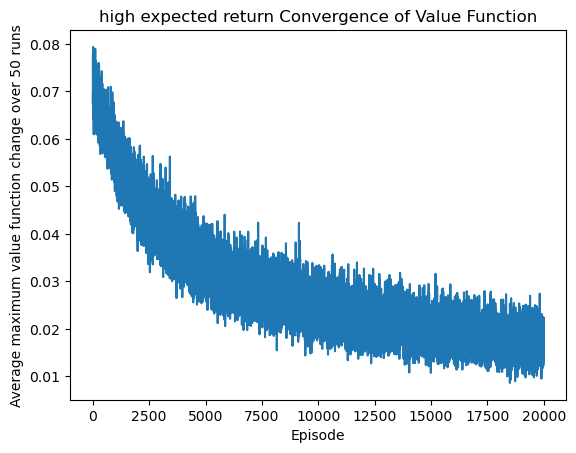

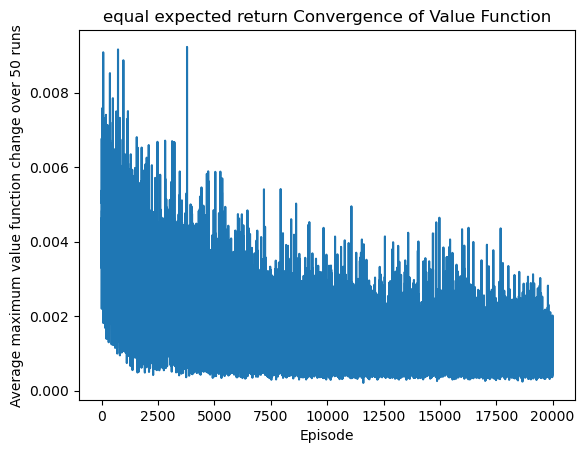

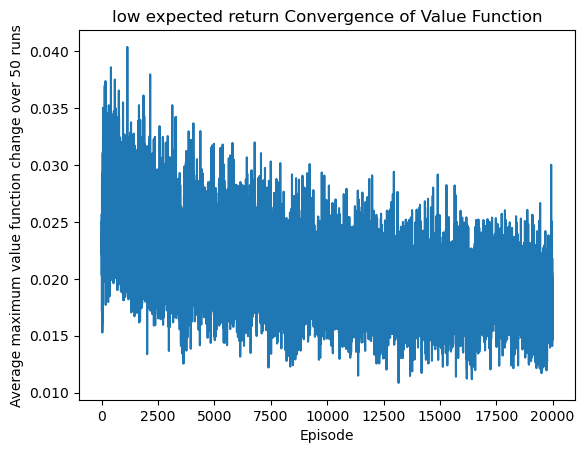

In [3]:
from more_itertools import chunked
for para in risky_return.keys():
    cvg_list = [sum(x) / len(x) for x in chunked(value_function_changes_list[para], 50)]
    plt.plot(cvg_list)
    plt.xlabel("Episode")
    plt.ylabel("Average maximum value function change over 50 runs")
    plt.title(f"{para} expected return Convergence of Value Function")
    plt.show()

In [5]:
optimal_choice = defaultdict(list)
benchmark1 = defaultdict(list)
benchmark2 = defaultdict(list)
benchmark3 = defaultdict(list)
benchmark4 = defaultdict(list)
opt_action_list = defaultdict(list)

for para in risky_return.keys():
  a, b, p = risky_return.get(para)
  W0 = 1
  for i in range(max_episodes):
    W_opt = W0
    W1 = W0
    W2 = W0
    W3 = W0
    W4 = W0
    for t in range(T):
      action_opt = optimal_policy((t, W_opt))
      action1 = 0.2
      action2 = 0.4
      action3 = 0.6
      action4 = 0.8
      if t <= 10:
        y = a if random.uniform(0, 1) < p else b
      if action_opt == "optimal_action":
        allocation = 1/(alpha*(a-b)*(1+r)**(T-t-1))*np.log(p*(a-r)/((1-p)*(r-b)))
      else:
        allocation = action_opt*W_opt

      W_opt = round(allocation * (y - r) + W_opt * (1 + r), 1)
      W1 = round(W1*action1 * (y - r) + W1 * (1 + r), 1)
      W2 = round(W2*action2 * (y - r) + W2 * (1 + r), 1)
      W3 = round(W3*action3 * (y - r) + W3 * (1 + r), 1)
      W4 = round(W4*action4 * (y - r) + W4 * (1 + r), 1)
    optimal_choice[para].append(W_opt)
    benchmark1[para].append(W1)
    benchmark2[para].append(W2)
    benchmark3[para].append(W3)
    benchmark4[para].append(W4)
    opt_action_list[para].append(action_opt)

In [7]:
for para in risky_return.keys():
    # Compute means
    oc_mean = np.mean(optimal_choice[para])
    ben1_mean = np.mean(benchmark1[para])
    ben2_mean = np.mean(benchmark2[para])
    ben3_mean = np.mean(benchmark3[para])
    ben4_mean = np.mean(benchmark4[para])

    # Compute utilities
    oc_utility = -np.exp(-alpha*oc_mean)/alpha
    ben1_utility = -np.exp(-alpha*ben1_mean)/alpha
    ben2_utility = -np.exp(-alpha*ben2_mean)/alpha
    ben3_utility = -np.exp(-alpha*ben3_mean)/alpha
    ben4_utility = -np.exp(-alpha*ben4_mean)/alpha

    print(f"For {para} expected return risky asset, the terminal wealth and utility:")
    print(f"1. Optimal Choice: Mean = {oc_mean:.4f}, Utility = {oc_utility:.4f}")
    print(f"2. Benchmark 1 (20%): Mean = {ben1_mean:.4f}, Utility = {ben1_utility:.4f}")
    print(f"3. Benchmark 2 (40%): Mean = {ben2_mean:.4f}, Utility = {ben2_utility:.4f}")
    print(f"4. Benchmark 3 (60%): Mean = {ben3_mean:.4f}, Utility = {ben3_utility:.4f}")
    print(f"5. Benchmark 4 (80%): Mean = {ben4_mean:.4f}, Utility = {ben4_utility:.4f}")
    print("-" * 60)  # Separator for readability

For high expected return risky asset, the terminal wealth and utility:
1. Optimal Choice: Mean = 2.1478, Utility = -8.0672
2. Benchmark 1 (20%): Mean = 1.6007, Utility = -8.5209
3. Benchmark 2 (40%): Mean = 1.8076, Utility = -8.3464
4. Benchmark 3 (60%): Mean = 1.9685, Utility = -8.2132
5. Benchmark 4 (80%): Mean = 2.0426, Utility = -8.1525
------------------------------------------------------------
For equal expected return risky asset, the terminal wealth and utility:
1. Optimal Choice: Mean = 1.6554, Utility = -8.4744
2. Benchmark 1 (20%): Mean = 1.5999, Utility = -8.5215
3. Benchmark 2 (40%): Mean = 1.6219, Utility = -8.5028
4. Benchmark 3 (60%): Mean = 1.5760, Utility = -8.5419
5. Benchmark 4 (80%): Mean = 1.4454, Utility = -8.6542
------------------------------------------------------------
For low expected return risky asset, the terminal wealth and utility:
1. Optimal Choice: Mean = 2.8039, Utility = -7.5549
2. Benchmark 1 (20%): Mean = 1.6003, Utility = -8.5212
3. Benchmark 2

# Unit test

In [8]:
import unittest

class TestQLearning(unittest.TestCase):
    def test_utility_func(self):
        W = 1.0
        alpha = 0.1
        self.assertAlmostEqual(utility_func(10, W, alpha), -9.048374180359595)
        self.assertEqual(utility_func(5, W, alpha), 0) # When t < 10, utility_func = 0

    def test_find_max_qvalue(self):
        dummy_Q = {
            ((0, 1.0), 0.2): -0.5,
            ((0, 1.0), 0.4): -0.3,
            ((0, 1.0), 0.6): -0.1,
        }
        state = (0, 1.0)
        max_value = find_max_qvalue(dummy_Q, state, "value")
        self.assertAlmostEqual(max_value, -0.1)
        max_action = find_max_qvalue(dummy_Q, state, "action")
        self.assertEqual(max_action, 0.6)

    def test_optimal_policy(self):
        initial_state = (0, 1.0)
        optimal_action = optimal_policy(initial_state)
        self.assertIn(optimal_action, action_space)
        max_q_value = find_max_qvalue(Q, initial_state, "value")
        self.assertAlmostEqual(Q[(initial_state, optimal_action)], max_q_value)

    def test_q_learning_convergence(self):
        initial_state = (0, 1.0)
        initial_q_value = Q[(initial_state, 0.2)]
        Q[(initial_state, 0.2)] += 1e-6
        self.assertAlmostEqual(Q[(initial_state, 0.2)], initial_q_value, delta=1e-5)

# Create a test suite and run it
if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestQLearning)
    unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.002s

OK
